# VARNN Training Codebase To Share

**Last Updated 3/4/2022**
1. Added VSN updated
2. Added Equation-by-Equation
3. Added support for different hemispheres
4. Execution Code Updated for different num variables, different methods of specifying hyperparams

In [4]:
11 % 6

5

In [ ]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 5.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from functools import reduce
from itertools import product

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime

from statsmodels.tsa.api import VAR

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

## Parameters for Model

### Variable Selection Networks

In [ ]:
# @title VSN Code

# num_features = variables here
# units = encoding dimension of each feature

class GatedLinearUnit(nn.Module):
  def __init__(self, input_size, units):
    super(GatedLinearUnit, self).__init__()
    self.linear1 = nn.Linear(input_size, units)
    self.linear2 = nn.Linear(input_size, units)
    self.sigmoid = nn.Sigmoid()

    self.input_size = input_size

  def forward(self, inputs):
    #print('glu input size', self.input_size)
    #print('glu input', inputs.shape)
    linear = self.linear1(inputs)
    sigmoid = self.sigmoid(self.linear2(inputs))
    # Element-wise product of linear layer and sigmoid layer
    out = linear * sigmoid
    #print('out', out.shape)
    return out

class GatedResidualNetwork(nn.Module):
  def __init__(self, input_size, units, dropout_rate):
    super(GatedResidualNetwork, self).__init__()
    self.elu_linear = nn.Linear(input_size, units)
    self.elu = nn.ELU()
    self.linear = nn.Linear(units, units)
    self.dropout = nn.Dropout(dropout_rate)
    self.gated_linear_unit = GatedLinearUnit(units, units)
    self.layer_norm = nn.LayerNorm(units)
    self.project = nn.Linear(input_size, units)
    
    self.input_size = input_size
    self.units = units
    
  def forward(self, inputs):
    #print('grn input size', self.input_size)
    #print('grn input', inputs.shape)
    x = self.elu_linear(inputs)
    x = self.elu(x)
    x = self.linear(x)
    x = self.dropout(x)
    # Add the original units to output of GLU to perform residual connection
    #print('x_size', x.shape)
    if inputs.shape[-1] != self.units:
      inputs = self.project(inputs)
    x = inputs + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x

# NEW VSN
class VariableSelection(nn.Module):
  def __init__(self, num_features, units, dropout_rate):
    super(VariableSelection, self).__init__()

    # Create a GRN for the concatenation of all the features
    self.grn_concat = GatedResidualNetwork(num_features, units, dropout_rate)
    self.softmax_linear = nn.Linear(units, num_features)

  def forward(self, inputs):
    # Code for this may be questionable
    #v = torch.cat(inputs)

    # size: num_obs x (features x units)
    v = self.grn_concat(inputs)
    # size: num_obs x units
    v = self.softmax_linear(v)
    v = F.softmax(v, dim = -1)
    # size: num_obs x features
    return v

### VARNN Code

In [ ]:
# @title CancelOut

class CancelOut(nn.Module):
    '''
    CancelOut Layer
    x - an input data (vector, matrix, tensor)
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True) + 4)
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [ ]:
# @title Fully Connected Network Architecture

class FCN(nn.Module):
  def __init__(self, n_features, n_outputs, dropout_rate, nodes, actv):
    super(FCN, self).__init__()

    # Assign the activation function
    exec('self.actv = %s'%actv)

    self.input = nn.Linear(n_features, nodes[0])
    self.hidden = nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)])
    self.output = nn.Linear(nodes[-1], n_outputs)
    self.dropout = nn.Dropout(p = dropout_rate)

  def forward(self, S):

    x = self.actv(self.input(S))
    x = self.dropout(x)

    for i in range(len(self.hidden)):
      x = self.actv(self.hidden[i](x))
      x = self.dropout(x)
    
    output = self.output(x)
    return output

**VARNN Notes**
- Input Dropout currently not working
- Prior shift currently not working (after hemispheres)

In [ ]:
# @title VAR NN Architecture Definition

class VARNN(nn.Module):
    def __init__(self, n_features, n_outputs, nodes, x_pos, dropout_rate, input_dropout_rate, 
                 cancel_out, vsn, fcn, neurons_weights, time_hemi_prior_variance,
                 device, actv = 'ReLU()', s_pos = None):
        super(VARNN, self).__init__()

        n_betas = []
        x_indices = []
        self.n_vars = len(x_pos)

        # Assign the activation function
        exec('self.actv = %s'%actv)
        
        s_indices = []
        for i in range(len(s_pos)):
          s_indices.append(torch.tensor(s_pos[i], dtype = torch.int64).to(device))
        self.s_pos = s_indices

        for i in range(self.n_vars):
          x_indices.append(torch.tensor(x_pos[i], dtype = torch.int64).to(device))
          n_betas.append(len(x_pos[i]))

        self.n_betas = n_betas
        self.n_alphas = int(n_outputs * (n_outputs+1) / 2)

        # Hemispheres
        # Number of hemispheres is number of lists within the s_pos list
        self.num_hemispheres = len(self.s_pos)
        self.time_hemi_prior_variance = time_hemi_prior_variance

        self.hemispheres = nn.ModuleList()

        for hemi_id in range(self.num_hemispheres):

          hemi_num_inputs = len(self.s_pos[hemi_id])

          # Defining the TVPL and Output layers - BETAS
          tvpl_all = []
          output_all = []

          for i in range(n_outputs):
            tvpl_var = []
            output_var = []
            for tvpl_archi in neurons_weights:
              # Define the TVPL NN for one layer 
              tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
              for layer_id in range(len(tvpl_archi) - 1):
                tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
              tvpl_var.append(nn.ModuleList(tvpl_list))
              output_var.append(nn.Linear(tvpl_archi[-1], 1))
            tvpl_all.append(nn.ModuleList(tvpl_var))
            output_all.append(nn.ModuleList(output_var))      

          # Defining TVPL and Output layers - ALPHAS
          tvpl_alphas = []
          output_alphas = []
          for i in range(self.n_alphas):
            # Just use the 1st tvpl archi for now - could change later
            tvpl_archi = neurons_weights[0]
            tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
            for layer_id in range(len(tvpl_archi) - 1):
              tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
            tvpl_alphas.append(nn.ModuleList(tvpl_list))
            output_alphas.append(nn.Linear(tvpl_archi[-1], 1))

          self.hemispheres.append(
              nn.ModuleDict({
              'betas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_all).to(device),
                'output': nn.ModuleList(output_all).to(device)
              }),
              'alphas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_alphas).to(device),
                'output': nn.ModuleList(output_alphas).to(device)
              })
              }))

        self.dropout = nn.Dropout(p = dropout_rate)
        self.input_dropout = nn.Dropout(p = 0)
        self.input_dropout_enabled = input_dropout_rate == 0
        self.device = device

        # Instantiate the VSN or FCN networks if applicable
        if vsn == True:
          self.vsn = VariableSelection(n_features, n_outputs, input_dropout_rate)
          pytorch_total_params = sum(p.numel() for p in self.vsn.parameters())
        else:
          self.vsn = None

        if fcn == True:
          self.fcn = FCN(n_features, n_outputs, dropout_rate, nodes, actv)
          pytorch_total_params = sum(p.numel() for p in self.fcn.parameters())
        else:
          self.fcn = None

        self.vsn_enabled = vsn
        self.fcn_enabled = fcn

        self.x_indices = x_indices
        self.n_layers = len(nodes)
        
        self.n_outputs = n_outputs
        self.neurons_weights = neurons_weights

    def forward(self, S):
      
      # Get the Xs for the linear part
      dat = torch.index_select(S, 1, self.x_indices[0])
      for i in range(1, self.n_vars):
        alt = torch.index_select(S, 1, self.x_indices[i])
        dat = torch.hstack([dat, alt])
      
      # Append constant column at the front
      dat = torch.hstack([torch.ones(S.size()[0], 1).to(self.device), dat])

      # Pure Fully-connected network if only that is enabled
      if self.fcn_enabled == True:
        y_hat = self.fcn(S)
        return y_hat, [], []

      # Pure VSN layer if only that is enabled
      if self.vsn_enabled == True:
        #print('input to vsn', S.shape)
        v = self.vsn(S)
        # NEW
        v = torch.mean(v, dim = 0)
        v_out = v.unsqueeze(0).repeat(S.shape[0],1) #becomes n_inputs x 1 -> 1 x n_inputs -> n_obs x n_inputs
        # S: n_obs x n_inputs
        S = torch.mul(S, v_out)
      else:
        v = []

      # Then do input layer dropout if activated
      # if self.input_dropout_enabled == True:
      #   S = self.input_dropout(S)

      betas_hemispheres = []
      alphas_hemispheres = []

      for hemi_id in range(self.num_hemispheres):
        # Subset the data going into that hemispheres
        S_hemi = torch.index_select(S, 1, self.s_pos[hemi_id])

        # Divide everything by the sqrt of number of parameters in hemisphere
        num_params = len(self.s_pos[hemi_id])
        S_hemi = S_hemi / (num_params ** 0.5)

        # Multiply by time hemisphere prior variance
        if self.num_hemispheres > 1 and hemi_id == self.num_hemispheres - 1:
          S_hemi = S_hemi * (self.time_hemi_prior_variance ** 0.5)
        
        # BETAS: Pass the data through beta hemispheres, output betas

        x = self.actv(self.hemispheres[hemi_id]['betas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['betas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['betas']['hidden'][i](x))
            x = self.dropout(x)

        betas = []

        for i in range(self.n_outputs):
          # For intercept
          x_i = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][0])):
            x_i = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][0][l](x_i))
          betas_alt = self.hemispheres[hemi_id]['betas']['output'][i][0](x_i)
          del x_i

          # For betas on the variables
          for j in range(1, sum(self.n_betas) + 1):
            x_b = torch.clone(x)
            for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][j])):
              x_b = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][j][l](x_b))
            alt = self.hemispheres[hemi_id]['betas']['output'][i][j](x_b)
            betas_alt = torch.cat([betas_alt, alt], dim = 1)
            del x_b
          betas.append(betas_alt)
          
        # betas
        betas_combined = torch.stack(betas, axis = 1)
        betas_hemispheres.append(betas_combined)

        # ALPHAS: Pass the data through alpha hemispheres, output alphas
        x = self.actv(self.hemispheres[hemi_id]['alphas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['alphas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['alphas']['hidden'][i](x))
            x = self.dropout(x)

        alphas = []

        for i in range(self.n_alphas):
          x_a = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['alphas']['tvpl'][i])):
            x_a = self.actv(self.hemispheres[hemi_id]['alphas']['tvpl'][i][l](x_a))
          alphas_alt = self.hemispheres[hemi_id]['alphas']['output'][i](x_a)
          del x_a
          alphas.append(alphas_alt)
        
        alphas_combined = torch.stack(alphas, axis = 1)
        alphas_hemispheres.append(alphas_combined)
      
      # Impose that the mean of the endog hemisphere is 0
      if len(betas_hemispheres) == 2:
        endog_hemi = betas_hemispheres[0]
        exog_hemi = betas_hemispheres[1]
        
        # hemi dim: n_obs x n_var x n_betas
        # Take the mean of the endog hemi over time
        endog_hemi_mean = torch.nanmean(endog_hemi, axis = 0)
        # Impose the endog hemi mean to be 0
        endog_hemi = endog_hemi - endog_hemi_mean
        exog_hemi = exog_hemi + endog_hemi_mean

        betas_hemispheres = [endog_hemi, exog_hemi]

      # Reorder alphas to the cholesky matrix
      cholesky_hemispheres = []
      for alpha_hemi in alphas_hemispheres:
        alpha_hemi = alpha_hemi.squeeze()
        # Construct precision matrix from the alphas
        n_vars = self.n_outputs
        # Lower-triangular Ct matrix
        c_t = torch.zeros((alpha_hemi.shape[0], n_vars, n_vars))
        i = 0
        for row in range(n_vars):
          for col in range(row+1):
            if row == col:
              # Absolute value for the diagonal elements of the cholesky matrix (6/2)
              c_t[:, row, col] = torch.abs(alpha_hemi[:, i])
            else:
              c_t[:, row, col] = alpha_hemi[:, i]
            i+=1
        cholesky_hemispheres.append(c_t)
      
      # Combine results from different hemispheres (general reduce function to allow for mult or sum)
      # Now we are using sum
      betas_reduced = reduce(lambda x, y: x + y, betas_hemispheres)
      cholesky_reduced = reduce(lambda x, y: x + y, cholesky_hemispheres)
      
      #c_t = n_obs x n_vars x n_vars
      # Multiply by transpose to get precision matrix
      precision = torch.bmm(cholesky_reduced, torch.permute(cholesky_reduced, (0, 2, 1)))
      
      # Generate predictions for this period (i.e. y_hat)
      y_hat = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, 0, :]), dim = 1), 1)
      for i in range(1, self.n_outputs):
        alt = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, i, :]), dim = 1), 1)
        y_hat = torch.hstack([y_hat, alt])

      with torch.no_grad():
        betas_hemispheres_stacked = torch.stack(betas_hemispheres, axis = -1)
        betas_hemispheres_stacked = torch.permute(betas_hemispheres_stacked, (0, 2, 1, 3))

        cholesky_hemispheres_stacked = torch.stack(cholesky_hemispheres, axis = -1)

      return y_hat, precision, betas_hemispheres_stacked, cholesky_hemispheres_stacked, v

In [ ]:
# @title Training Loop (with New Loss)

def training_loop_new(X_train, Y_train, model, criterion, optimizer, scheduler, train_indices, nn_hyps):

  num_epochs = nn_hyps['epochs']
  loss_weights = nn_hyps['loss_weights']
  n_vars = Y_train.shape[1]

  wait = 0
  best_epoch = 0
  best_loss = float('inf')
  
  # Loss matrix, dim: num_epochs x num_variables
  loss_matrix = np.empty((num_epochs, n_vars))
  loss_matrix[:] = np.nan
  loss_matrix_oob = np.empty((num_epochs, n_vars))
  loss_matrix_oob[:] = np.nan

  # Get the OOB indices (not in train_indices)
  oob_indices = [e for e in range(X_train.shape[0]) if e not in train_indices]
  train_losses = []
  oob_losses = []
  oob_mse = []
  
  v_matrix = np.empty((num_epochs, X_train.shape[1]))

  for epoch in range(num_epochs):

    loss_vars = []
    loss_vars_oob = []

    model.train()
    optimizer.zero_grad()

    if nn_hyps['joint_estimation'] == False:
      ## Getting in-sample errors
      for var in range(n_vars): # Loop through all variables
        Y_pred, _, betas, _, v = model(X_train[train_indices, :])
        loss = criterion(Y_pred[:, var], Y_train[train_indices, var])
        loss_matrix[epoch, var] = float(loss)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss = loss * w
        loss_vars.append(loss)
        
        if type(v) is list:
          pass
        else:
          v_matrix[epoch, :] = v.detach().cpu().numpy()

      loss = torch.mean(torch.hstack(loss_vars))
      l1_input = l1_reg_input(model) 
      l1_input_loss = l1_input * nn_hyps['l1_input_lambda']
      l0_input = l0_reg_input(model)
      l0_input_loss = l0_input * nn_hyps['l0_input_lambda']
      loss += (l1_input_loss + l0_input_loss)

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()
  
      # Get OOB loss
      for var in range(n_vars):
        Y_pred_oob, _, _, _, _ = model(X_train[oob_indices, :])
        loss_oob = criterion(Y_pred_oob[:, var], Y_train[oob_indices, var])
        loss_matrix_oob[epoch, var] = float(loss_oob)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss_oob = loss_oob * w
        loss_vars_oob.append(loss_oob)

      loss_oob = torch.mean(torch.hstack(loss_vars_oob))
      oob_losses.append(float(loss_oob))

      if epoch % 40 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}')


    else: # Joint estimation
      Y_pred, precision, betas, alphas, v = model(X_train[train_indices, :])

      # Get the residuals
      residuals = Y_pred - Y_train[train_indices, :]
      precision = precision.to(device)

      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']

      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())

      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()

      # Get OOB Loss 
      Y_pred, precision, betas, alphas, v = model(X_train[oob_indices, :])
      residuals = Y_pred - Y_train[oob_indices, :]
      precision = precision.to(device)
      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']
      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss_oob = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())
      
      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))
      if epoch % 40 == 0:
        print(f'OOB Mean Log Det Precision: {mean_log_det_p}, MSE: {mse}')

      oob_losses.append(float(loss_oob))
      oob_mse.append(float(mse))

      if epoch % 40 == 0:
        lr_now = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}, LR: {lr_now}')

    ## Early Stopping

    pct_change = (best_loss - loss_oob) / loss_oob 
    # If current epoch improved on the best OOB loss, update best_loss, best_epoch and best_model to current
    if best_loss > loss_oob or epoch == 0:
      best_loss = loss_oob
      best_epoch = epoch
      best_model = copy.deepcopy(model)

      # If model improved more than tol, set wait to 0
      if pct_change > nn_hyps['tol'] or epoch == 0:
        wait = 0
      else: # If model improve less than tol, increment wait
        wait = wait + 1
    else: # If current epoch did not improve, increment wait
      wait = wait + 1

    # Early stopping if wait exceeds patience
    if wait > nn_hyps['patience']:
      lr_end = optimizer.param_groups[0]['lr']
      print(f'Early stopped, best epoch: {best_epoch}, train loss: {train_losses[best_epoch]}, best OOB loss: {best_loss}, LR: {lr_end}')
      break

  # Plot the training curves
  plt.figure()

  ax1 = plt.subplot()
  l1, = ax1.plot(train_losses[1:], label = 'Train Loss', color = 'blue')
  l2, = ax1.plot(oob_losses[1:], label = 'OOB Loss', color = 'orange')
  ax2 = ax1.twinx()
  l3, = ax2.plot(oob_mse[1:], label = 'OOB MSE', color = 'red')
  plt.legend([l1, l2, l3], ['Train Loss', 'OOB Loss', 'OOB MSE'])
  plt.show()

  out = {
         'best_model': best_model,
         'v': v_matrix,
         'loss_matrix': loss_matrix,
         'loss_matrix_oob': loss_matrix_oob,
         'best_train_loss': train_losses[best_epoch],
         'best_oob_loss': best_loss}

  return out

### Calculate the Loss Weights (by running the Autoregression separately for each variable on training data)
def get_mse_weights(X, Y, n_lags, trend = 't'):

  mse_weights = []
  # For each Y variable
  for i in range(Y.shape[1]):
    y = Y[:, i]
    res = AutoReg(y, lags = n_lags, trend = 't').fit()
    # Get predictions
    y_pred = res.predict(start = 0, end = -1)
    # Get MSE
    mse = np.mean((y_pred - y[n_lags:]) ** 2)
    mse_weights.append(mse)

  return mse_weights

In [ ]:
# @title Scaling Functions and L1/L0

# Scale data
def scale_data(X_train, Y_train, X_test, Y_test):
  # Standardize the variables
  scaler_x = StandardScaler()
  X_train_scaled = scaler_x.fit_transform(X_train)
  X_test_scaled = scaler_x.transform(X_test)

  scaler_y = StandardScaler()
  Y_train_scaled = scaler_y.fit_transform(Y_train)
  Y_test_scaled = scaler_y.transform(Y_test)

  # Warning: sigma_x gives slightly different values from the R version (could be due to estimator of variance n-1)

  return {
      'X_train': X_train_scaled,
      'X_test': X_test_scaled,
      'Y_train': Y_train_scaled,
      'Y_test': Y_test_scaled,
      'mu_x': scaler_x.mean_,
      'sigma_x': np.sqrt(scaler_x.var_),
      'mu_y': scaler_y.mean_,
      'sigma_y': np.sqrt(scaler_y.var_),
      'scaler_x': scaler_x,
      'scaler_y': scaler_y
  }

# Invert scaling
def invert_scaling(scaled, mu, sigma):
  inverted = scaled * sigma + mu
  return inverted

def l1_reg_input(model):
  l1 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l1 += torch.sum(torch.abs(param))
      break
  return l1
  
  
def l0_reg_input(model, tol = 1e-5):
  l0 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l0 += torch.sum(torch.abs(param) > tol)
      break
  return l0

### VARNN Code

In [ ]:
# @title VARNN Training Wrapper Function

def build_VARNN(X, Y, train_indices, nn_hyps, device):

  if nn_hyps['s_pos']:
    s_pos = list(itertools.chain(*nn_hyps['s_pos']))
    n_features = len(s_pos)
  else:
    n_features = X.shape[1]

  n_outputs= len(nn_hyps['x_pos'])
  if nn_hyps['eqn_by_eqn'] == True:
    models = []
    results_all = []
    for var in range(n_outputs):
      print(f'Start Estimating Equation {var}')
      model = VARNN(n_features = n_features, 
                n_outputs= 1,
                nodes = nn_hyps['nodes'],
                x_pos = nn_hyps['x_pos'],
                dropout_rate = nn_hyps['dropout_rate'],
                input_dropout_rate = nn_hyps['input_dropout_rate'],
                cancel_out = nn_hyps['cancel_out'],
                vsn = nn_hyps['vsn'],
                fcn = nn_hyps['fcn'],
                neurons_weights = nn_hyps['neurons_weights'],
                time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                actv = nn_hyps['actv'],
                device = device,
                s_pos = nn_hyps['s_pos'])
      models.append(model)
      pytorch_total_params = sum(p.numel() for p in model.parameters())
      print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)

      criterion = nn.MSELoss()
      optimizer = nn_hyps['optimizer']
      if optimizer == 'RMSprop':
        optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'SGD':
        optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'RAdam':
        optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
      else:
        optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])

      lmda = lambda epoch: nn_hyps['lr_multiple']
      scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)
      model = model.to(device)
      
      # Train the built VARNN on one variable and return the results
      results = training_loop_new(X, Y[:,var:(var+1)], model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
      results_all.append(results)
    return results_all

  else:
    model = VARNN(n_features = n_features, 
                  n_outputs= len(nn_hyps['x_pos']), 
                  nodes = nn_hyps['nodes'],
                  x_pos = nn_hyps['x_pos'],
                  dropout_rate = nn_hyps['dropout_rate'],
                  input_dropout_rate = nn_hyps['input_dropout_rate'],
                  cancel_out = nn_hyps['cancel_out'],
                  vsn = nn_hyps['vsn'],
                  fcn = nn_hyps['fcn'],
                  neurons_weights = nn_hyps['neurons_weights'],
                  time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                  actv = nn_hyps['actv'],
                  device = device,
                  s_pos = nn_hyps['s_pos'])
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)
      
    criterion = nn.MSELoss()

    optimizer = nn_hyps['optimizer']
    if optimizer == 'RMSprop':
      optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'SGD':
      optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'RAdam':
      optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
    else:
      optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])


    lmda = lambda epoch: nn_hyps['lr_multiple']
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)

    # scheduler = optim.lr_scheduler.CyclicLR(optimizer_obj, base_lr = nn_hyps['lr'] / 2, max_lr = nn_hyps['lr'] * 4, 
    #                                         step_size_up = 50, 
    #                                         step_size_down = 50, cycle_momentum = False)
    
    model = model.to(device)
    
    # Training the built VARNN and return the results
    results = training_loop_new(X, Y, model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
    
    return results

In [ ]:
# @title VARNN Inner Bootstrap Function

# Build_VARNN() is a helper function used within this wrapper function
def conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device):

  x_pos_flat = list(itertools.chain(*nn_hyps['x_pos']))

  n_obs = X_train.shape[0]
  n_vars = Y_train.shape[1]
  n_betas = len(x_pos_flat) + 1
  n_hemispheres = len(nn_hyps['s_pos'])

  # Conduct prior shift
  if nn_hyps['prior_shift'] == True:
    x_pos_ps = sorted(list(itertools.chain(*nn_hyps['x_pos_ps'])))

    # Isolate the lags that we calculate PS from
    X_train_temp = X_train[:, x_pos_ps]
    # Add constant
    X_train_temp = sm.add_constant(X_train_temp)

    # Run linear regression, get the betas
    lin_reg = sm.OLS(Y_train, X_train_temp)
    ps_model = lin_reg.fit()

    X_test_temp = X_test[:, x_pos_ps]
    X_test_temp = sm.add_constant(X_test_temp)
    # Get predictions of var.fitted
    Y_train_fitted = ps_model.predict(X_train_temp)
    Y_test_fitted = ps_model.predict(X_test_temp)

    # Multiply predictions by the strength parameter
    Y_train_fitted = Y_train_fitted * nn_hyps['prior_shift_strength']
    Y_test_fitted = Y_test_fitted * nn_hyps['prior_shift_strength']

    # Subtract fitted values to get residuals
    Y_train = Y_train - Y_train_fitted
    Y_test = Y_test - Y_test_fitted

  else:
    ps_model = None
    x_pos_ps = None
    Y_train_fitted = 0.0
    Y_test_fitted = 0.0

  # Scaling
  if nn_hyps['standardize'] == True:
    scale_output = scale_data(X_train, Y_train, X_test, Y_test)
    X_train = scale_output['X_train']
    X_test = scale_output['X_test']
    Y_train = scale_output['Y_train']
    Y_test = scale_output['Y_test']

  # Get the loss weights
  mse_weights = get_mse_weights(X_train, Y_train, n_lags = nn_hyps['n_lag_linear'])
  nn_hyps.update({'loss_weights': mse_weights})

  # Convert to tensors
  X_train = torch.tensor(np.array(X_train), dtype = torch.float).to(device)
  X_test = torch.tensor(np.array(X_test), dtype = torch.float).to(device)
  Y_train = torch.tensor(np.array(Y_train), dtype = torch.float).to(device)
  Y_test = torch.tensor(np.array(Y_test), dtype = torch.float).to(device)

  ### 3: Conduct Bootstrapping

  num_bootstrap = nn_hyps['num_bootstrap']
  opt_bootstrap = nn_hyps['opt_bootstrap']
  sampling_rate = nn_hyps['sampling_rate']
  block_size = nn_hyps['block_size']
  bootstrap_indices = nn_hyps['bootstrap_indices']
  oob_loss_multiple_threshold = nn_hyps['oob_loss_multiple_threshold']

  # Matrix to store all predictions for every bootstrap run
  # pred_in_ensemble are the OOB results, pred_ensemble are the test results
  pred_in_ensemble = np.empty((X_train.shape[0], num_bootstrap, n_vars))
  pred_in_ensemble[:] = np.nan
  pred_ensemble = np.empty((X_test.shape[0], num_bootstrap, Y_test.shape[1]))
  pred_ensemble[:] = np.nan

  # Matrix to store ensembled predictions
  pred_in = np.empty((X_train.shape[0], n_vars))
  pred_in[:] = np.nan
  pred = np.empty((X_test.shape[0], Y_test.shape[1]))
  pred[:] = np.nan

  # Store the errors
  mse_in_ensemble = np.empty(num_bootstrap)
  mse_in_ensemble[:] = np.nan
  mse_ensemble = np.empty(num_bootstrap)
  mse_ensemble[:] = np.nan
  
  # Matrix to store all betas: dim is len(X) x n_betas (n_vars+1) x n_bootstraps x n_vars
  betas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_draws[:] = np.nan
  betas_in_draws[:] = np.nan

  # Matrix to store all sigmas
  sigmas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_draws[:] = np.nan
  sigmas_in_draws[:] = np.nan

  # Matrix to store precision matrix and choleksy of precision
  precision_draws = np.zeros_like(sigmas_draws)
  precision_in_draws = np.zeros_like(sigmas_in_draws)
  precision_draws[:] = np.nan
  precision_in_draws[:] = np.nan

  cholesky_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars, n_hemispheres,
                           num_bootstrap))
  cholesky_in_draws = np.zeros_like(cholesky_draws)
  cholesky_draws[:] = np.nan
  cholesky_in_draws[:] = np.nan
  
  # Store models and values
  trained_model = []
  v_matrix = []
  bootstrap_indexes = []

  accepted_bootstraps = 0
  ## 3A: Sample bootstrap indices
  # For each bootstrap iteration, choose the training indices (boot), and the oob
  # oos is just the testing indices
  # Then conduct the model training, and save the results
  for j in range(num_bootstrap):

    print(f'Bootstrap iteration {j} at time {datetime.now()}')

    if bootstrap_indices: # If bootstrap indices are provided in nn_hyps, then no need to sample inside
      boot = bootstrap_indices[j]['in_sample']
      oob = bootstrap_indices[j]['oob']
      oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    else: # Sample the bootstraps
      if opt_bootstrap == 1: # Individual obs bootstrap
        k = int(sampling_rate * X_train.shape[0])

        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = [e for e in list(range(X_train.shape[0])) if e not in boot]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if opt_bootstrap == 2: # Block bootstrap
        # Select the size of first block
        first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
        # Get the starting ids of the blocks
        block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

        # If last block size < half of block size
        last_block_size = n_obs - block_start_ids[-1]
        if last_block_size < block_size / 2:
          block_start_ids.remove(block_start_ids[-1])

        num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
        oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
        # Get the OOB indices
        oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
          for e in oob_blocks]))
        
        boot = [e for e in list(range(n_obs)) if e not in oob]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if sampling_rate == 1:
        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = range(X_train.shape[0])
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    models = []
    # 3B: Use the bootstrap indices as the training indices for the model
    if nn_hyps['eqn_by_eqn'] == False:
      model_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      model = model_out['best_model'].to(device)
    else:
      models_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      for e in models_out:
        models.append(e['best_model'].to(device))
    
    # Reject the model if the OOB loss is much higher than train loss
    # oob_loss_multiple = model_out['best_oob_loss'] / model_out['best_train_loss']
    # if oob_loss_multiple > oob_loss_multiple_threshold:
    if False:
      print(f'Rejected inner bootstrap {j}, ratio: {oob_loss_multiple}')
    else:
      accepted_bootstraps += 1
      # 4: Inverting the scaling and storing the estimated predictions and betas

      if nn_hyps['eqn_by_eqn'] == False:
        in_preds, in_precision, in_betas, in_cholesky, _ = model(X_train[boot, :])
        oob_preds, oob_precision, oob_betas, oob_cholesky, _ = model(X_train[oob, :])
        test_preds, test_precision, test_betas, test_cholesky, _ = model(X_test)
        del model

      else:
        raise NotImplementedError('Not implemented for eqn by eqn True')

      # Add the regularization to the preicision matrix
      in_precision = in_precision.detach().cpu().numpy()
      oob_precision = oob_precision.detach().cpu().numpy()
      test_precision = test_precision.detach().cpu().numpy()
      
      if nn_hyps['lambda_temper_epochs'] == False:
        in_precision = in_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), in_precision.shape[0], axis = 0)
        oob_precision = oob_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), oob_precision.shape[0], axis = 0)
        test_precision = test_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), test_precision.shape[0], axis = 0)

      # Save covariance matrices by inverting precision matrix
      sigmas_in_draws[boot, :, :, j] = np.linalg.inv(in_precision)
      sigmas_draws[oob, :, :, j] = np.linalg.inv(oob_precision)
      sigmas_draws[oos, :, :, j] = np.linalg.inv(test_precision)

      # Save precision matrix
      precision_in_draws[boot, :, :, j] = in_precision
      precision_draws[oob, :, :, j] = oob_precision
      precision_draws[oos, :, :, j] = test_precision

      # Save cholesky
      cholesky_in_draws[boot, :, :, :, j] = in_cholesky.detach().cpu().numpy()
      cholesky_draws[oob, :, :, :, j] = oob_cholesky.detach().cpu().numpy()
      cholesky_draws[oos, :, :, :, j] = test_cholesky.detach().cpu().numpy()

      if nn_hyps['standardize'] == True:
        pred_in_ensemble[oob, j, :] = invert_scaling(oob_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        pred_ensemble[:, j, :] = invert_scaling(test_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        
        if nn_hyps['fcn'] == False:

            # Un-standardize the covariance matrix
            for i in range(n_vars): # multiply each row, and each column
              sigmas_in_draws[:, i, :, j] = sigmas_in_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_in_draws[:, :, i, j] = sigmas_in_draws[:, :, i, j] * scale_output['sigma_y'][i]

              sigmas_draws[:, i, :, j] = sigmas_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_draws[:, :, i, j] = sigmas_draws[:, :, i, j] * scale_output['sigma_y'][i]

            # Store the betas
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

            # Copy the standardized betas
            betas_in_draws_std = betas_in_draws.copy()
            betas_draws_std = betas_draws.copy()

            for i in range(n_vars):
              # Invert scaling for the constant term
              for hemi in range(n_hemispheres):
                betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
                betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
    
              # For non-constant terms
              for k in range(1, n_betas):
                # Scale the kth beta
                for hemi in range(n_hemispheres):
                  betas_draws[:, k, j, i, hemi] = betas_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] - betas_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]
      
                  betas_in_draws[:, k, j, i, hemi] = betas_in_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] - betas_in_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]

      else: # If not standardizing
        pred_in_ensemble[oob, j, :] = oob_preds.detach().cpu().numpy()
        pred_ensemble[:, j, :] = test_preds.detach().cpu().numpy()
        
        if nn_hyps['fcn'] == False:
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

  # Add the prior shift betas back
  if nn_hyps['prior_shift'] == True:
    pass
    # DOES NOT WORK AFTER HEMISPHERES

    # ps_params = ps_model.params * nn_hyps['prior_shift_strength']
    # ps_params = np.expand_dims(ps_params, axis = [0, 2])
    # ps_params = np.repeat(ps_params, repeats = X_train.shape[0] + X_test.shape[0], axis = 0)
    # ps_params = np.repeat(ps_params, repeats = num_bootstrap, axis = 2)
    # betas_in_draws = betas_in_draws + ps_params
    # betas_draws = betas_draws + ps_params

  ### 5: Take the median of the bootstrapped values (needed for forecasting)
  betas = np.nanmedian(betas_draws, axis = 2) # n_periods x n_betas x n_vars (= n_equations)
  pred_in = np.nanmedian(pred_in_ensemble, axis = 1) # n_periods x n_vars
  pred = np.nanmedian(pred_ensemble, axis = 1) # n_periods x n_vars

  # Add the prior shift back
  pred_in = pred_in + Y_train_fitted
  pred = pred + Y_test_fitted

  return {'betas': betas,
          'betas_in_draws': betas_in_draws,
          'betas_draws': betas_draws,
          'betas_in_draws_std': betas_in_draws_std,
          'betas_draws_std': betas_draws_std,
          'sigmas_in_draws': sigmas_in_draws,
          'sigmas_draws': sigmas_draws,
          'precision_in_draws': precision_in_draws,
          'precision_draws': precision_draws,
          'cholesky_in_draws': cholesky_in_draws,
          'cholesky_draws': cholesky_draws,
          'pred_ensemble': pred_ensemble, 
          'pred_in_ensemble': pred_in_ensemble,
          'pred_in': pred_in,
          'pred': pred,
          'oos_index': oos,
          'v_matrix': v_matrix,
          'trained_model': trained_model,
          'scale_output': scale_output,
          'x_pos_ps': x_pos_ps,
          'ps_model': ps_model
          }

In [ ]:
# @title Predict NN Function

def predict_nn(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, results['pred_in'].shape[1]))
  for i in range(num_inner_bootstraps):
    # Use new feature matrix to get predictions for next period
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()
    pred_mat[:, i, :] = pred

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = pred_mat.mean(axis = 1)

  # Invert scaling of the prediction
  if results['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
  
  # Add back the oos adj
  pred = pred + pred_oos_adj

  return pred

**Execution**

- Time Dummy Setting: 0) linear + quad + cubic, added n_time_trends times 1) time dummies 2) time dummies new (PGC) 3) both time dummies and trends  4) just 1 linear time trend

In [ ]:
# @title Process VARNN Data

# Wrapper function to process all the VARNN data

def process_varnn_data(data, nn_hyps, marx = True, test_size = 60, n_time_trends = 0, time_dummy_setting = 0, dummy_interval = 12):

  n_var = data.shape[1]
  var_name = list(x_d.columns)
  data = data.copy()

  n_lag_d = nn_hyps['n_lag_d']
  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_ps = nn_hyps['n_lag_ps']

  # 2: Generating the lags
  for lag in range(1, n_lag_d + 1):
    for col in var_name:
      data[f'{col}.l{lag}'] = data[col].shift(lag)

  data = data.dropna()

  y_mat = np.array(data.iloc[:, :n_var]) # Target vairables (n_vars)
  x_mat = np.array(data.iloc[:, n_var:]) # Explanatory variables (lags of target variables + other exogenous variables)
  x_mat_colnames = data.iloc[:, n_var:].columns
  
  if marx == True:
    # Computing MARX (moving averages)
    x_mat_marx = np.array(x_mat)

    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        # For earlier lags, set earliest lagged value to be the mean of all more recent lags
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        x_mat_marx[:, who_to_avg[-1]] = x_mat[:, who_to_avg].mean(axis = 1)

    x_mat_marx_colnames = ['MARX_' + e for e in x_mat_colnames]
    print('Size of x_mat before appending MARX', x_mat[:, :(n_var * n_lag_linear)].shape)
    print('Size of x_mat_marx', x_mat_marx.shape)

    # Concatenate
    x_mat_all = np.hstack([x_mat[:, :(n_var * n_lag_linear)], x_mat_marx])
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_linear)]) + list(x_mat_marx_colnames)

    print('x_mat_all size', x_mat_all.shape)
  
  else: # If no MARX
    x_mat_all = np.array(x_mat)
    x_mat_all = x_mat_all[:, :(n_var * n_lag_d)]
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_d)])

    print('x_mat_all size', x_mat_all.shape)
  size_before_time = x_mat_all.shape[1]

  ### Create time dummies based on different methods

  if time_dummy_setting == 0: # Linear + Quad + Cubic time trend
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3

    # Add time trend
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  elif time_dummy_setting == 1: # Time dummies (1/0, no overlap)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 2: # PGCtime dummies (1/0, overlapping)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.ones((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 0 if ( int(t / dummy_interval) <= i) else 1

    random_mat = np.random.randn(x_mat_all.shape[0], n_dummies) * 0.001
    time_dummies = time_dummies + random_mat
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 3: # Both time dummies and time trends 
  # (essentially settings 0 and 1 combined)
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 4: # Only linear trend
    time_trends = np.zeros((x_mat_all.shape[0], 1))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  print('Size of X_train afer appending time', x_mat_all.shape, f'Time dummy setting: {time_dummy_setting}')

  # Train-test split
  X_train = x_mat_all[:-test_size, :]
  X_test = x_mat_all[-test_size:, :]
  Y_train = y_mat[:-test_size, :]
  Y_test = y_mat[-test_size:, :]

  # If time dummies, set test time dummy values to the same as the last value
  if time_dummy_setting in [1,2,3]:
    X_test[:, size_before_time:] = X_train[-1, size_before_time:]

  # Get the index of the lagged values of unemployment rate
  first_parts = ['.l' + str(lag) for lag in range(1, n_lag_linear + 1)]
  first_parts_ps = ['.l' + str(lag) for lag in range(1, n_lag_ps + 1)]

  get_xpos = lambda variable_name, first_parts: [list(i for i, n in enumerate(x_mat_all_colnames) if n == variable_name + first_part)[0] for first_part in first_parts]

  x_pos = {}
  for var in var_name:
    x_pos[var] = get_xpos(var, first_parts)

  print('x_pos', x_pos)

  # Put x_pos back into the list (NN function needs it like that for now)
  x_pos = list(x_pos.values())

  if nn_hyps['prior_shift'] == True:
    x_pos_ps = {}
    for var in var_name:
      x_pos_ps[var] = get_xpos(var, first_parts_ps)
    x_pos_ps = list(x_pos_ps.values())
  else:
    x_pos_ps = None

  # Only input the time trend into nonlinear part
  nn_hyps.update({'x_pos': x_pos, 
                  'x_pos_ps': x_pos_ps})
  print('Size of X_train', X_train.shape)

  return X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps

### Loading Data

In [ ]:
# Loading the Data - 7-variables Monthly

data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all['L0_HOUST'] = x_d_all['L0_HOUST'].diff()
x_d_all = x_d_all.dropna()
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Execution Code

**Define Experiment Parameters**

In [ ]:
# PARAMETERS
num_inner_bootstraps = 50
num_repeats = 2

nn_hyps = {
    # Mostly unchanged hyperparameters
    'epochs': 500,
    'show_train': 3,
    'opt_bootstrap': 2,
    'num_bootstrap': num_inner_bootstraps, 
    'sampling_rate': 0.75,
    'block_size': 24,
    'cancel_out': False,
    'standardize': True,
    'prior_shift': False,
    'oob_loss_multiple_threshold': 5,
    'save_models': False,

    # Hyperparamters of interest - but not changed in this experiment
    'tvpl_archi': [50, 50],
    'patience': 50,
    'tol': 0.0001,
    'lr': 0.001,
    'lr_multiple': 0.9975,
    'nodes': [200, 200, 200],
    'marx': True,
    'dummy_interval': 6,
    'l1_input_lambda': 0,
    'l0_input_lambda': 0,
    'precision_lambda': 0,
    'input_dropout_rate': 0,
    'vsn': False, 
    'fcn': False, 
    'eqn_by_eqn': False,
    'fix_bootstrap': False,
    'time_hemi_prior_variance': 1,
    'loss_weight_param': 0.5,
    'prior_shift_strength': 0, 
    'log_det_multiple': 1,
    'optimizer': 'Adam',
    'n_lag_d': 8, 'n_lag_linear': 2, 'n_lag_ps': 2,
    'variables': ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
}

In [ ]:
# @title Old Params
# OPTION 3: Manually specify experiment params
experiment_params = [{'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 
                      'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': 'Baseline'},
                    #  {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0002, 
                    #   'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': 'Low LR'},
                    #  {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [100,100], 'lr': 0.0005, 
                    #   'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': '100x2 TVPL'},
                     {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.SELU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 
                      'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': 'SELU'},
                    #  {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 
                    #   'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': '200x3'},
                     {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 
                      'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0.25, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': 'Dropout 0.25'},
                    #  {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.002, 
                    #   'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': True, 'name': 'High LR'},
                     {'n_lag_linear': 2, 'n_lag_ps': 2, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 
                      'optimizer': 'Adam', 'time_dummy_setting': 0, 'dropout_rate': 0, 'eqn_by_eqn': False, 'vsn': False, 's_pos_setting': {'is_hemi': True, 'n_times': 10}, 'joint_estimation': False, 'name': 'Joint Off'},
                     ]

# 6/5 params
# OPTION 3: Manually specify experiment params
experiment_params = [{'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': 'Baseline'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 4, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 1}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': '1 Time Trend'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 100}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': '100 Time Trends'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': False, 'n_times': 0}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': 'No Time Trend'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 1, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': 'Time Dummies'},
                     {'nodes': [100,100], 'actv': 'nn.SELU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': 'SELU'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 'log_det_multiple': 0.25, 'name': 'No Dropout'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': False, 'log_det_multiple': 0.25, 'name': 'Joint Off'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 'log_det_multiple': 1, 'name': 'Log Det Multiple 1'}
]

In [ ]:
# 7 Jun Joint Estimation
experiment_params = [
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': [list(range(30, 153)), list(range(30, 153))], 'log_det_multiple': 1, 'name': '2 Hemis PGC Dummies'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'name': 'PGC Dummies + Endog'},
                     {'nodes': [100], 'actv': 'nn.ReLU()', 'tvpl_archi': [25], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'PGC Dummies + Endog Small'},
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'PGC Dummies + Endog Large'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.5, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'name': 'PGC Dummies + Endog Dropout 0.5'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 1, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': [list(range(30, 153)), list(range(30, 153))], 'log_det_multiple': 1, 'name': '2 Hemis Old Dummies'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.1, 'name': 'PGC Dummies + Endog, Precision Lambda 0.1'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.25, 'name': 'PGC Dummies + Endog, Precision Lambda 0.25'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.5, 'name': 'PGC Dummies + Endog, Precision Lambda 0.5'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 1, 'name': 'PGC Dummies + Endog, Precision Lambda 1'},
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': False, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'Joint Off'},    
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'Joint Off PGC Dummies'},   
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.1, 'name': 'Trends Lambda 0.1'},    
                     {'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 0, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 30}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.25, 'name': 'Trend Lambda 0.25'}, 
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'PGC Dummies (Fixed) + Endog Large'},              
]


In [ ]:
experiment_params = [{'n_lag_d': 12, 'n_lag_linear': 6, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'name': 'PGC Dummies + Endog'},
                     {'n_lag_d': 12, 'n_lag_linear': 6, 'nodes': [100,100], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 'log_det_multiple': 1, 'name': 'Joint Off'},                
]

In [ ]:
experiment_params = [
                     {'nodes': [200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 'lambda_temper_epochs': 50,
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.1, 'name': 'PGC Dummies + Endog Large'},
                     {'nodes': [200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 'lambda_temper_epochs': 50,
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.1, 'name': 'Joint Off'}
]

In [ ]:
# @title Get Bootstrap Indices

# Function to generate the same bootstrap indices, so they can be constant across the different experiments for hyp tuning

def get_bootstrap_indices(num_bootstrap, n_obs, block_size, sampling_rate, opt_bootstrap):

  bootstrap_indices = []

  for j in range(num_bootstrap):
    if opt_bootstrap == 1:
      # Sample the bootstrap indices
      k = int(sampling_rate * n_obs)

      in_sample = sorted(random.sample(list(range(n_obs)), k = k))
      oob = [e for e in list(range(X_train.shape[0])) if e not in in_sample]

    if opt_bootstrap == 2: # Block bootstrap
      # Select the size of first block
      first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
      # Get the starting ids of the blocks
      block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

      # If last block size < half of block size
      last_block_size = n_obs - block_start_ids[-1]
      if last_block_size < block_size / 2:
        block_start_ids.remove(block_start_ids[-1])

      num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
      oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
      # Get the OOB indices
      oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
        for e in oob_blocks]))
      
      in_sample = [e for e in list(range(n_obs)) if e not in oob]

    bootstrap_indices.append({'in_sample': in_sample, 'oob': oob})
  return bootstrap_indices

In [ ]:
# Specify Lists of #Variables you want the experiment to run over
variable_lists = [
#                 ['inf', 'unrate'],
#                 ['inf', 'unrate', 'DGS3'],
#                 ['inf', 'unrate', 'DGS3', 'house_starts'],
 #                ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate'],
                  ['inf', 'unrate', 'DGS3', 'house_starts']
]

### Execution

In [ ]:
experiment_name = '20jun_jointestimation'
test_size = 90

folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

for variable_list in variable_lists:
  # Select variables for experiment
  print('Variables', variable_list)
  x_d = x_d_all.copy()
  x_d = x_d[variable_list]
  x_d_colnames = x_d.columns
  var_names = x_d.columns
  n_var = len(var_names)
  nn_hyps['variable_list'] = variable_list

  train_size = x_d.shape[0] - test_size - nn_hyps['n_lag_d']
  if nn_hyps['fix_bootstrap'] == True:
    bootstrap_indices = get_bootstrap_indices(num_bootstrap = num_inner_bootstraps, n_obs = train_size, block_size = nn_hyps['block_size'], sampling_rate = nn_hyps['sampling_rate'], opt_bootstrap = nn_hyps['opt_bootstrap'])
    nn_hyps['bootstrap_indices'] = bootstrap_indices
  else:
    nn_hyps['bootstrap_indices'] = None

  # Save experiment param list
  with open(f'{folder_path}/params.npz', 'wb') as f:
      np.savez(f, params = experiment_params, date = datetime.now())

  for repeat in range(num_repeats):
    for i in range(len(experiment_params)):

      nn_hyps.update(experiment_params[i])

      n_betas = n_var * nn_hyps['n_lag_linear'] + 1
      n_inputs_wo_time = n_var * (nn_hyps['n_lag_linear'] + nn_hyps['n_lag_d'])

      X_train, X_test, Y_train, Y_test, _, _, nn_hyps = process_varnn_data(x_d, nn_hyps, test_size = test_size, n_time_trends = 100, time_dummy_setting = nn_hyps['time_dummy_setting'], marx = nn_hyps['marx'], dummy_interval = nn_hyps['dummy_interval'])

      n_inputs_total = X_train.shape[1]
      nn_hyps['neurons_weights'] = [nn_hyps['tvpl_archi'] for i in range(n_betas)]

      # If s_pos is already not defined (s_pos can be defined by user)
      if not nn_hyps.get('s_pos'):
        # s_pos_setting
        if nn_hyps['s_pos_setting']['is_hemi'] == False:
          nn_hyps['s_pos'] = [ list(range(n_inputs_total)) ]
        else:
          n_inputs_total_new = n_inputs_wo_time + nn_hyps['s_pos_setting']['n_times']
          nn_hyps['s_pos'] = [ list(range(n_inputs_wo_time)), list(range(n_inputs_wo_time, n_inputs_total_new))]
          # Subset the X_train and X_test to only the required columns
          X_train = X_train[:, :n_inputs_total_new]
          X_test = X_test[:, :n_inputs_total_new]
      print(nn_hyps['s_pos'])
    
      results = conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device)

      BETAS = results['betas_draws']
      BETAS_IN = results['betas_in_draws']
      SIGMAS = results['sigmas_draws']
      SIGMAS_IN = results['sigmas_in_draws']
      PRECISION = results['precision_draws']
      PRECISION_IN = results['precision_in_draws']
      CHOLESKY = results['cholesky_draws']
      CHOLESKY_IN = results['cholesky_in_draws']
      PREDS = results['pred_in_ensemble'] 
      PREDS_TEST = results['pred_ensemble']

      with open(f'{folder_path}/{n_var}var_params_{i}_repeat_{repeat}.npz', 'wb') as f:
        np.savez(f, betas = BETAS, betas_in = BETAS_IN, 
                 sigmas = SIGMAS, sigmas_in = SIGMAS_IN,
                 precision = PRECISION, precision_in = PRECISION_IN,
                 cholesky = CHOLESKY, cholesky_in = CHOLESKY_IN,
                 train_preds = PREDS, test_preds = PREDS_TEST, 
                 y = Y_train, y_test = Y_test, 
                 params = nn_hyps)
      
      del nn_hyps['s_pos']

Output hidden; open in https://colab.research.google.com to view.

### Quick Evaluation

Should do evaluation in 'Evaluation' Code to compare multiple experiments

**Investigating Precision Matrix**

In [ ]:
### VAR standardized precision matrix

# Estimate the VAR
var_model_estimated = VAR(x_d)
var_fit = var_model_estimated.fit(2)
var_resid = var_fit.resid
# Get standardized residuals
var_resid_std = var_resid / x_d.std()
var_resid_std_cov_mat = var_resid_std.cov()
# Get the standardized precision matrix
var_resid_std_precision_mat = np.linalg.inv(var_resid_std_cov_mat)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
import numpy.ma as ma

In [ ]:
# VARNN time-invariant precision matrix
#varnn_resid = np.repeat(np.expand_dims(Y_train, axis = 1), PREDS.shape[1], axis = 1) - PREDS
# Get standardized residuals
varnn_resid_std = varnn_resid / np.array(x_d.std())
varnn_resid_std_precision_mat = np.zeros((3,3,100))
for b in range(100):
  varnn_resid_std_cov_mat = ma.cov(ma.masked_invalid(varnn_resid_std[:, b, :]), rowvar = False).data
  # Get the standardized precision matrix
  varnn_resid_std_precision_mat[:,:,b] = np.linalg.inv(varnn_resid_std_cov_mat)
varnn_resid_std_precision_mat_median = np.median(varnn_resid_std_precision_mat, axis = -1)

In [ ]:
var_resid_std_precision_mat

array([[ 1.74941677,  0.10444287, -0.12787275],
       [ 0.10444287,  1.03866002,  0.05414682],
       [-0.12787275,  0.05414682,  1.21551435]])

In [ ]:
varnn_resid_std_precision_mat_median

array([[ 2.00525885, -0.03134171, -0.17078142],
       [-0.03134171,  7.01644955,  0.50849814],
       [-0.17078142,  0.50849814,  1.83177529]])

In [ ]:
# VARNN time-varying precision matrix
varnnj_precision_mat = PRECISION_IN

In [ ]:
# Prove that cov mat calculation w nan values works
a = np.array([[2, 5],
              [10, -1],
              [np.nan, np.nan],
              [0, 7]])
print(ma.cov(ma.masked_invalid(a), rowvar = False))

b = np.array([[2, 5],
              [10, -1],
              [0, 7]])
print(ma.cov(ma.masked_invalid(b), rowvar = False))

[[28.0 -22.0]
 [-22.0 17.333333333333332]]
[[28.0 -22.0]
 [-22.0 17.333333333333332]]


In [ ]:
out = np.load(f'drive/MyDrive/EconML DL/2022 Experiments/8jun_simulation/dataset_1_params_1_repeat_0.npz', allow_pickle = True)
SIGMAS = out['sigmas']
SIGMAS_IN = out['sigmas_in']
BETAS_IN = out['betas_in']
BETAS = out['betas']
PRECISION = out['precision']
PRECISION_IN = out['precision_in']

var_names = ['inf', 'unrate', 'DGS3']

No handles with labels found to put in legend.


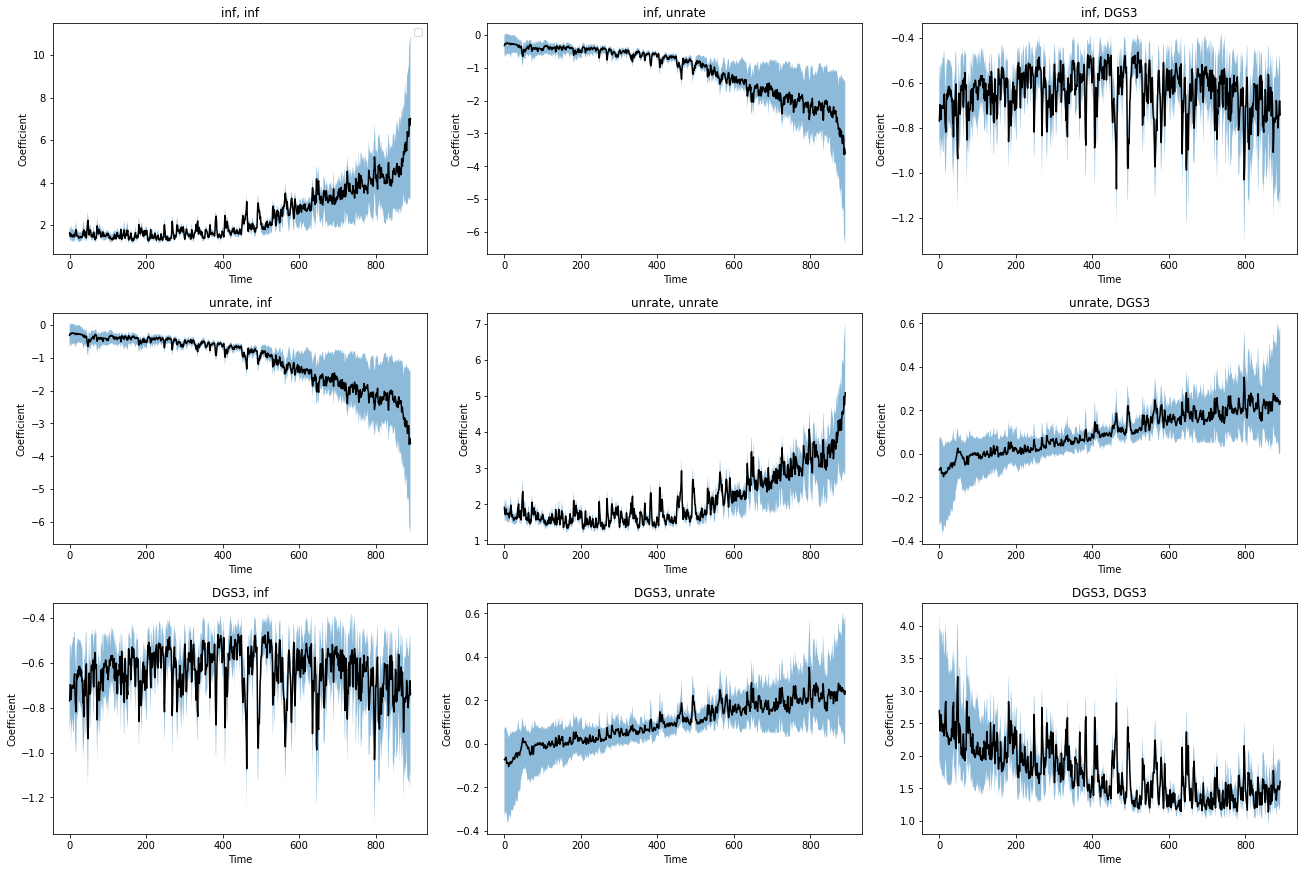

In [ ]:
# Plot the covariance matrix over time

n_vars = SIGMAS_IN.shape[1]

fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

for row in range(n_vars):
  for col in range(n_vars):

    # for i in range(SIGMAS_IN.shape[3]):
    #   axs[row, col].plot(SIGMAS_IN[:, row, col, i], lw = 0.5, alpha = 0.25, label = i)

    axs[row, col].plot(np.nanmedian(PRECISION_IN[:, row, col, :], axis = -1), color = 'black')
    axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Coefficient')

    precision_in_lcl = np.nanquantile(PRECISION_IN[:, row, col, :], axis = -1, q = 0.16)
    precision_in_ucl = np.nanquantile(PRECISION_IN[:, row, col, :], axis = -1, q = 0.84)
    axs[row, col].fill_between(list(range(PRECISION_IN.shape[0])), precision_in_lcl, precision_in_ucl, alpha = 0.5)

    # # Plot the time-invariant covariance matrix from VARNN
    # axs[row, col].axhline(y = varnn_resid_std_precision_mat_median[row, col], color = 'red', label = 'VARNN')
    # axs[row, col].axhline(y = np.nanquantile(varnn_resid_std_precision_mat, axis = -1, q = 0.16)[row, col], color = 'red', ls = '--')
    # axs[row, col].axhline(y = np.nanquantile(varnn_resid_std_precision_mat, axis = -1, q = 0.84)[row, col], color = 'red', ls = '--')
    # # Plot the time-invariant covariance matrix from VAR
    # axs[row, col].axhline(y = var_resid_std_precision_mat[row, col], color = 'blue', label = 'VAR')

    if row == 0 and col == 0:
      axs[row,col].legend()

**Plotting Covariance Matrix**

In [ ]:
cov_mat = np.zeros((25, 3, 3))
for b in range(25):
  cov_mat[b, :, :] = pd.DataFrame(resids[:, b, :]).dropna().cov()
cov_mat_median = np.nanmedian(cov_mat, axis = 0)

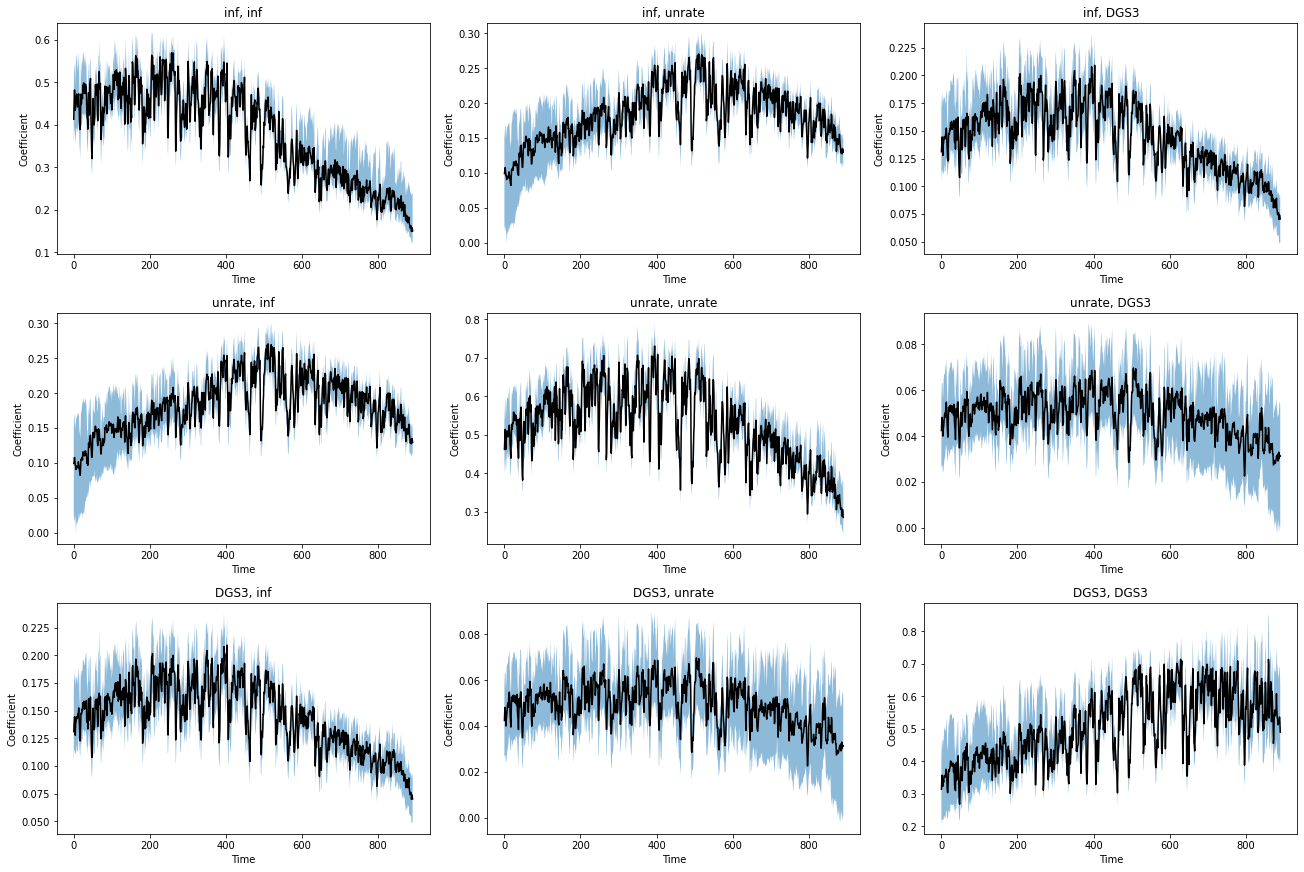

In [ ]:
# Plot the covariance matrix over time

n_vars = SIGMAS_IN.shape[1]

fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

for row in range(n_vars):
  for col in range(n_vars):

    # for i in range(SIGMAS_IN.shape[3]):
    #   axs[row, col].plot(SIGMAS_IN[:, row, col, i], lw = 0.5, alpha = 0.25, label = i)

    axs[row, col].plot(np.nanmedian(SIGMAS_IN[:, row, col, :], axis = -1), color = 'black')
    axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Coefficient')

    sigmas_in_lcl = np.nanquantile(SIGMAS_IN[:, row, col, :], axis = -1, q = 0.16)
    sigmas_in_ucl = np.nanquantile(SIGMAS_IN[:, row, col, :], axis = -1, q = 0.84)
    axs[row, col].fill_between(list(range(SIGMAS_IN.shape[0])), sigmas_in_lcl, sigmas_in_ucl, alpha = 0.5)

    # # Plot the time-invariant covariance matrix
    # axs[row, col].axhline(y = np.nanmedian(cov_mat_median[row, col]), color = 'black', label = 'Time-Invariant')

    # if row == 0 and col == 0:
    #   axs[row,col].legend()

In [ ]:
n_lag_linear = 2
# For experiments with more than 1 lag, get the ids of the 1st beta to plot
beta_ids_to_keep = [0] + list(range(1, BETAS_IN.shape[1], n_lag_linear))
print(beta_ids_to_keep)
BETAS_IN_PLOT = BETAS_IN[:, beta_ids_to_keep, :,:,:]

[0, 1, 3, 5]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
num_inner_bootstraps = 100

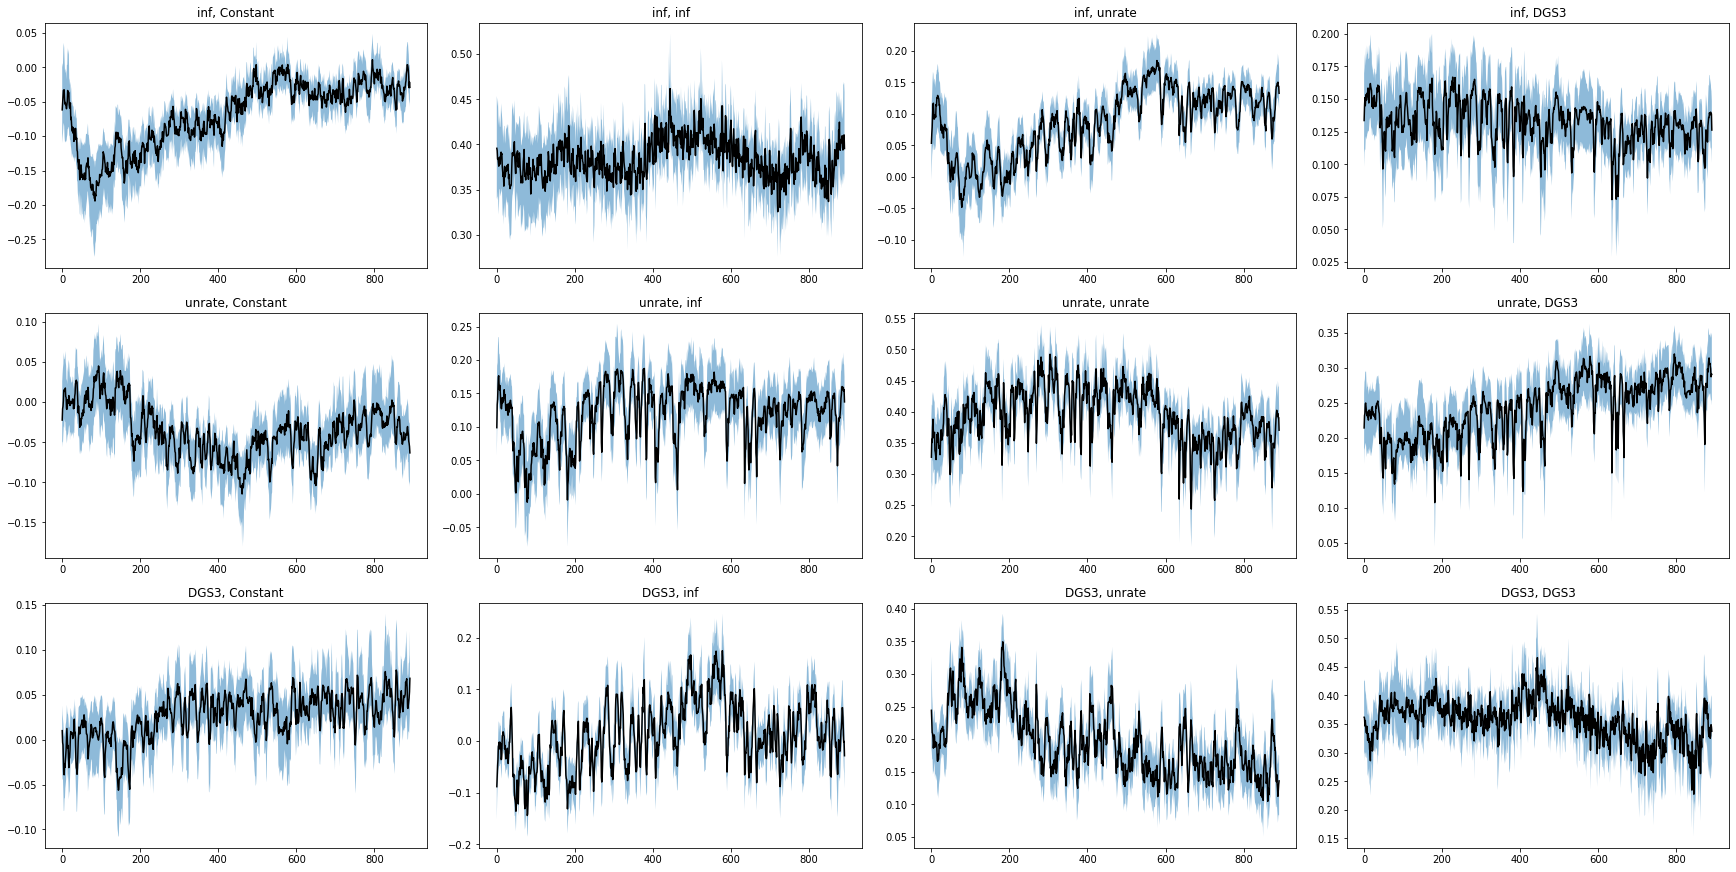

In [ ]:
### (For plotting experiments of same model but over different train/test samples)
n_vars = BETAS_IN_PLOT.shape[3]
n_betas = BETAS_IN_PLOT.shape[1]
betas_names = ['Constant'] + list(var_names)
fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

for var in range(n_vars):
  for beta in range(n_betas):
    BETAS_THIS = np.sum(BETAS_IN_PLOT[:, beta, :, var, :], axis = -1)
    # for i in range(num_inner_bootstraps):
    #   # Plot for the combined TVP (across all hemispheres) first
    #   axs[var, beta].plot(BETAS_THIS[:, i], lw = 0.5, alpha = 0.25)
    BETAS_THIS_median = np.nanmedian(BETAS_THIS, axis = 1)
    axs[var, beta].plot(BETAS_THIS_median, color = 'black')
    axs[var, beta].set_title(f'{var_names[var]}, {betas_names[beta]}')
      
    betas_in_lcl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.16)
    betas_in_ucl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.84)
    axs[var, beta].fill_between(list(range(BETAS_THIS_median.shape[0])), betas_in_lcl, betas_in_ucl, alpha = 0.5)